# Import Library

In [1]:
!pip install indo_normalizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 78.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from indo_normalizer import Normalizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download data NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# --- Load Dataset ---
file_path = "/content/drive/MyDrive/Indonesia AI/Fundamental NLP/Project 1/Data_raw/tweet.csv"
df = pd.read_csv(file_path)

# Cleaning Text

In [5]:
# --- Text Normalizer ---
normalizer = Normalizer()

# Daftar stopwords standar dari NLTK
stop_words_standard = set(stopwords.words('indonesian'))

# Daftar kata-kata penting yang TIDAK BOLEH dihapus (pengecualian)
list_stopwords_exceptions = [
    'baik','maju','hebat','berhasil','kuat','setuju','mantap','yakin','terus','murah','adil','lancar',
    'mulia','bangga','cemerlang','senang','keren','optimis','menang','sukses','terbukti','sejahtera',
    'bagus','terbaik','solusi','amanah','jujur','peduli','tegas','pintar',
    'tidak','bukan','jangan','belum','gagal','jelek','susah','mahal','rugi','hancur','lemah','salah',
    'keliru','buruk','parah','bingung','mengecewakan','bohong','kacau','nyungsep','menjerit','terpuruk',
    'turun','kurang','goblok','tolol'
]

list_stopwords_include = [
    'jokowi', 'ekonomi', 'prabowosalahkansby', 'pilihorangbaik', 'pilihbajuputih',
    'pilihjelasislamnya', 'jokowimenangtotaldebat'
]
custom_stopwords_exceptions = set(list_stopwords_exceptions)


# --- DAFTAR STOPWORD FINAL ---

# Hapus kata-kata pengecualian dari daftar gabungan. Ini adalah daftar final yang akan kita gunakan.
final_stop_words = (stop_words_standard - custom_stopwords_exceptions) | set(list_stopwords_include)


# --- BUAT SATU FUNGSI PREPROCESSING UTAMA ---

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Hapus karakter non-ASCII (Untuk mengatasi emoji dan mojibake)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+|pic.twitter.com\S+|t.co|S+', '', text, flags=re.MULTILINE)
    # Hapus @username dan #hashtag
    text = re.sub(r'\@|#', '', text)
    # Hapus tanda baca, angka, dan karakter spesial
    text = re.sub(r'[^a-zA-Z\s | ? ]', '', text)
    # Normalize menggunakan indo_normalizer
    normalized_tuple = normalizer.normalize_text(text)
    text = normalized_tuple[0] # Extract the normalized text from the tuple


    # Tokenisasi (memecah teks menjadi daftar kata)
    tokens = word_tokenize(text)

    # Menghapus stopwords menggunakan daftar final kita
    tokens = [word for word in tokens if word not in final_stop_words]


    # Menggabungkan kembali token menjadi string
    return ' '.join(tokens)


# --- Eksekusi pada DataFrame ---
df['tweet_bersih']   = df['tweet'].apply(preprocess_text)

print('Hasil setelah preprocessing')
print(df[['tweet','sentimen','tweet_bersih']].head())

print('\n','='*50,'\n')
print('Statistik sentimen setelah preprocessing')
print(df['sentimen'].value_counts())

Korpus '/usr/local/lib/python3.12/dist-packages/indo_normalizer/corpus/common_words.txt' berhasil dimuat. (18122 kata)
Korpus '/usr/local/lib/python3.12/dist-packages/indo_normalizer/corpus/slangs.csv' berhasil dimuat. (1284 pasangan)
Hasil setelah preprocessing
                                               tweet sentimen  \
0  Kata @prabowo Indonesia tidak dihargai bangsa ...  negatif   
1  Batuan Langka, Tasbih Jokowi Hadiah dari Habib...   netral   
2  Di era Jokowi, ekonomi Indonesia semakin baik....   netral   
3  Bagi Sumatera Selatan, Asian Games berdampak p...  positif   
4  Negara kita ngutang buat bngun infrastruktur y...  negatif   

                                        tweet_bersih  
0  prabowo indonesia tidak dihargai bangsa asing ...  
1  batuan langka hadiah habib luthfi seharga mercy ?  
2        era indonesia baik indonesiamaju jokowilagi  
3  sumatera selatan asian games berdampak percaya...  
4  negara ngutang bingung infrastruktur dipakai m...  


Statistik sent

In [6]:
# # --- FEATURE ENGINEERING ---
# # 1. Membuat fitur dari teks (TF-IDF)
# vectorizer = TfidfVectorizer(max_features=700, min_df=3, ngram_range=(1, 3))
# X_tfidf = vectorizer.fit_transform(df['tweet_bersih'])

# # 2. Membuat fitur 'ada_tanda_tanya'
# X_feature_tanya = df['tweet'].apply(lambda x: 1 if '?' in str(x) else 0)

# # --- PENGGABUNGAN FITUR ✨---
# # Menggabungkan matriks TF-IDF dengan fitur baru kita.
# # .values.reshape(-1, 1) mengubah pandas Series menjadi format yang benar untuk digabungkan.
# X = hstack([X_tfidf, X_feature_tanya.values.reshape(-1,1)])

# # --- MENDEFINISIKAN TARGET ---
# y = df['sentimen']


# # --- SELESAI PREPROCESSING ---
# print("✅ Tahap Preprocessing Selesai!")
# print(f"Bentuk (shape) matriks fitur X final: {X.shape}")
# print(f"Bentuk (shape) target y final: {y.shape}")

# Visualisasi Word Cloud

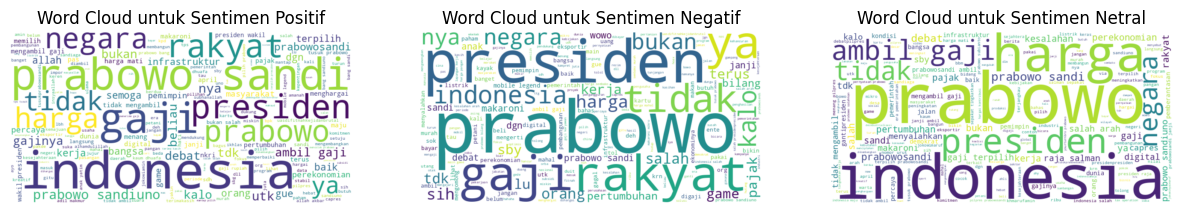

In [7]:
positif_text_updated = ' '.join(df[df['sentimen'] == 'positif']['tweet_bersih'])
negatif_text_updated = ' '.join(df[df['sentimen'] == 'negatif']['tweet_bersih'])
netral_text_updated = ' '.join(df[df['sentimen'] == 'netral']['tweet_bersih'])

wordcloud_positif_upd = WordCloud(width=800, height=400, background_color='white').generate(positif_text_updated)
wordcloud_negatif_upd = WordCloud(width=800, height=400, background_color='white').generate(negatif_text_updated)
wordcloud_netral_upd = WordCloud(width=800, height=400, background_color='white').generate(netral_text_updated)

plt.figure(figsize=(15,8))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positif_upd, interpolation='bilinear')
plt.title('Word Cloud untuk Sentimen Positif')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negatif_upd, interpolation='bilinear')
plt.title('Word Cloud untuk Sentimen Negatif')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_netral_upd, interpolation='bilinear')
plt.title('Word Cloud untuk Sentimen Netral')
plt.axis('off')

plt.show()

In [8]:
df[['sentimen', 'tweet_bersih']].to_csv('tweet_bersih.csv', index=False)